In [31]:
# #ephemeris sim
# using LinearAlgebra
# #make sure to cite this package
# using SPICE
# using Downloads: download 
# using DifferentialEquations
# using Plots

In [32]:
using DifferentialEquations
using LinearAlgebra
using Plots
using SPICE

In [33]:
# using Pkg
# Pkg.activate()

In [34]:
using DelimitedFiles
xtraj  = readdlm("xtraj.txt", '\t', Float64, '\n')

#in days
time_steps = readdlm("time.txt", '\t', Float64, '\n')
#period 

T_periodic_n = 3.414975410587678

3.414975410587678

In [35]:
xtraj

6×131 Matrix{Float64}:
     4.3125e5      4.3125e5       4.3125e5   …      4.3125e5      4.3125e5
     0.0           2.11866        4.21631        -974.27         -0.00385146
  2286.77       2286.77        2286.77           2285.38       2286.77
     0.0           0.0301068      0.0599152       -13.9354        0.00219923
 15649.0       15649.0        15649.0           15640.9       15649.0
     0.0          -0.0967975     -0.192635   …     44.5037        0.000129386

In [36]:
# Load leap seconds kernel
#furnsh("/home/faustovega/Desktop/astrodynamics_nasa_work/naif0012.tls")

# laptop 
furnsh("/home/fausto/naif0012.tls")

In [37]:
# Convert the calendar date to ephemeris seconds past J2000

#was 2018
#et = utc2et("2018-02-06T20:45:00")

et = 0

0

In [38]:
# Load a planetary ephemeris kernel
#furnsh("/home/faustovega/Desktop/astrodynamics_nasa_work/de440.bsp")

#laptop
furnsh("/home/fausto/de440.bsp")

In [39]:
#gravitational parameters for the bodies (km3/s2)

#moon 
μ_m = 4902.80058214776

#earth
μ_e = 398600.432896939

#sun
μ_s = 132712440017.987

1.32712440017987e11

In [40]:
#units used to normalize
#also in km and seconds

#distance
l_star = 385692.50

#time
t_star = 377084.152667038

#in km
lunar_radius = 1738.2 

1738.2

In [41]:
μ_earth_moon = 1.215058560962404E-2

0.01215058560962404

In [42]:
pose_m1 = [-μ_earth_moon*l_star , 0, 0]

3-element Vector{Float64}:
 -4686.389740239921
     0.0
     0.0

In [43]:
function hat(x)

    ω_hat = [0 -x[3] x[2]; x[3] 0 -x[1]; -x[2] x[1] 0]

    return ω_hat
    
end

hat (generic function with 1 method)

In [44]:
#get the ECI state given a state in the rotating coordinate frame 
#all in km and s
function cr3bp_to_ephem(x_r, time)

    #state in the ECI ra
    x_eci = zeros(6)

    #time is already wrt et
    
    #state of the moon (position and velocity) relative to Earth (in km and km/s)
    moon_state = spkezr("moon",time,"J2000","NONE","earth")[1]

    #position of the moon relative to Earth
    r_moon = moon_state[1:3]

    #velocity of the moon relative to Earth
    v_moon = moon_state[4:6]

    #x component of the rotating frame expressed in inertial coordinates
    x̃ = r_moon/norm(r_moon)
    #z component of the rotating frame expressed in inertial coordinates
    z̃ = cross(r_moon, v_moon)/norm(cross(r_moon, v_moon))
    #x component of the rotating frame expressed in inertial coordinates
    ỹ = cross(z̃, x̃)

    #instantanous rotation matrix from rotating frame to inertial frame (centered at Earth)
    eci_R_r = [x̃ ỹ z̃]

    #cr3bp assumes that the rotating frame is rotating by the mean motion 

    θ_dot_mm = 2*pi/2.361e6
    #instantanous angular velocity
    #θ_dot = norm(cross(r_moon, v_moon))/(norm(r_moon)^2)
    #θ_dot_2 = (cross(r_moon, v_moon)/(norm(r_moon)^2))[3]

    #println("theta dot 2: ", θ_dot_2)

    ω = [0, 0, θ_dot_mm]

    ω_hat= hat(ω)
    
    #position transformation
    x_eci[1:3] = eci_R_r*(x_r[1:3] - pose_m1)

    x_eci[4:6] = eci_R_r*x_r[4:6] + eci_R_r*ω_hat*(x_r[1:3] - pose_m1)

    return x_eci
end

cr3bp_to_ephem (generic function with 1 method)

In [45]:
test = [431249.946141646,
0.0,
2286.769716989665,
0.0,
0.1811228748758214,
0.0]

6-element Vector{Float64}:
 431249.946141646
      0.0
   2286.769716989665
      0.0
      0.1811228748758214
      0.0

In [51]:
#this matches the pavlack paper
ephem_sim = cr3bp_to_ephem(test, 0)

6-element Vector{Float64}:
 -315699.8428590055
 -289709.0899557205
  -80299.25699339015
       0.918770690350011
      -0.8884391404312567
      -0.4068140719442202

In [47]:
#something is wrong with the integration...

In [48]:
function just_dynamics_integrate(x_0, period)
    
    tspan = (0.0, period)
    prob = ODEProblem(ephem_dynamics!, x_0, tspan)
    sol = solve(prob, TsitPap8(), abstol=1e-12, reltol=1e-12)
    
    return sol
    
end

just_dynamics_integrate (generic function with 1 method)

In [49]:
function ephemeris_model_EarthMoon(x, t)

    xdot = zeros(6)

    xdot[1:3] = x[4:6]

    #position of the spacecraft relative to the earth 
    r_qi = x[1:3]

    time = et + t

    #get positions of moon and sun relative to earth 
    rqj_moon = spkpos("moon", time, "J2000", "none", "earth")[1]
    
    rij_moon = rqj_moon- r_qi 

    #r_qi - vector that defines the position of the satellite wrt Earth
    #rqj is the position of a planetary body wrt satellite

    #just Earth and Moon
    xdot[4:6] = (-μ_e/(norm(r_qi))^3)*r_qi + μ_m.*((rij_moon/norm(rij_moon)^3)-(rqj_moon/norm(rqj_moon)^3));


    return xdot

end

ephemeris_model_EarthMoon (generic function with 1 method)

In [50]:
function ephem_dynamics!(du, u, p, t)
    
    #dependence on time
    du[1:6] = ephemeris_model_EarthMoon(u[1:6], t)
    
    #no dependence on time
    #du[1:6] = ephemeris_model_Earth(u[1:6])
    
end

ephem_dynamics! (generic function with 1 method)

In [54]:
time_steps_s = time_steps*86400

131×1 Matrix{Float64}:
   0.0
  11.697359139965018
  23.27874742489753
  37.184103746805235
  59.0195302877028
  82.00807239391601
 110.33890232618462
 139.16053995286458
 171.75197949393433
 211.33393177580447
   ⋮
   1.1989630166289548e6
   1.2107651091746096e6
   1.2223891936145483e6
   1.2340062417344307e6
   1.2453673276059336e6
   1.2565472951957565e6
   1.267261519310328e6
   1.277847659736725e6
   1.2832276226493693e6

In [55]:
sol = just_dynamics_integrate(ephem_sim, time_steps_s[2])

retcode: Success
Interpolation: 3rd order Hermite
t: 6-element Vector{Float64}:
  0.0
  0.08703832327062344
  0.40209830608330305
  1.3577799269382518
  4.528703267121751
 11.697359139965018
u: 6-element Vector{Vector{Float64}}:
 [-315699.8428590055, -289709.0899557205, -80299.25699339015, 0.918770690350011, -0.8884391404312567, -0.4068140719442202]
 [-315699.7628907275, -289709.167283957, -80299.29240180131, 0.9187710963114669, -0.8884387579198088, -0.4068139904632128]
 [-315699.4734224902, -289709.44719523867, -80299.4205725637, 0.9187725658025191, -0.8884373733081167, -0.4068136955184261]
 [-315698.5953663053, -289710.2962565007, -80299.8093565081, 0.918777023238234, -0.8884331732954424, -0.40681280084242716]
 [-315695.68197134975, -289713.11338789156, -80301.09932400679, 0.9187918126738421, -0.8884192375049335, -0.4068098322213157]
 [-315689.09534918645, -289719.4820467465, -80304.01557964241, 0.9188252466913176, -0.8883877306615361, -0.4068031202816901]

In [56]:
function get_state(solution)
    
    N = size(solution.u)[1]

    all_states = zeros(6, N)

    for i=1:N
        all_states[:,i] = solution.u[i][1:6]
    end
    
    #all states and all stm are functions of t
    #solution.t is the time
    return all_states
end

get_state (generic function with 1 method)

In [57]:
all_states = get_state(sol)

6×6 Matrix{Float64}:
     -3.157e5        -3.157e5    …      -3.15696e5      -3.15689e5
     -2.89709e5      -2.89709e5         -2.89713e5      -2.89719e5
 -80299.3        -80299.3           -80301.1        -80304.0
      0.918771        0.918771           0.918792        0.918825
     -0.888439       -0.888439          -0.888419       -0.888388
     -0.406814       -0.406814   …      -0.40681        -0.406803

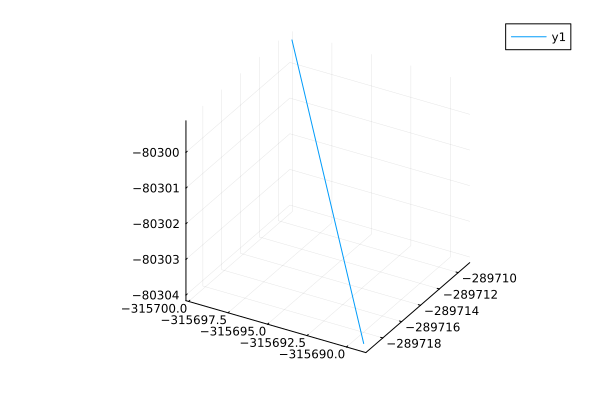

In [58]:
plot(all_states[1,:], all_states[2,:], all_states[3,:])

In [61]:
test = [xtraj[1:3,2]; xtraj[4:6,2]/86400]

6-element Vector{Float64}:
 431249.94614368404
      2.11865931416171
   2286.769710437147
      3.484585934851936e-7
      0.18112287443374192
     -1.1203414652143744e-6

In [66]:
check = cr3bp_to_ephem(test, time_steps_s[2])

6-element Vector{Float64}:
 -315689.9424349923
 -289718.6632164918
  -80303.64059953278
       0.9188019332724429
      -0.8884100872465213
      -0.4068069566510115

In [67]:
all_states[:,2]

6-element Vector{Float64}:
 -315699.7628907275
 -289709.167283957
  -80299.29240180131
       0.9187710963114669
      -0.8884387579198088
      -0.4068139904632128

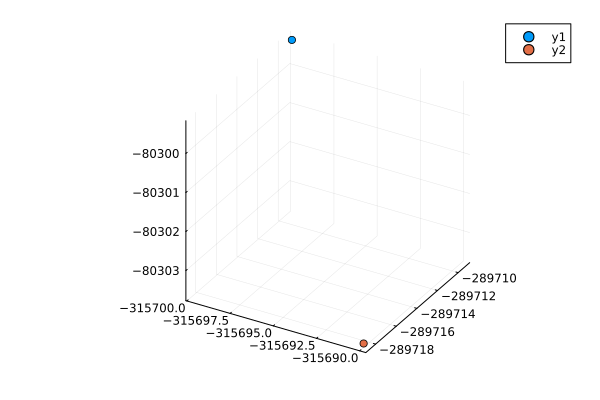

In [69]:
scatter([all_states[1,2]], [all_states[2,2]], [all_states[3,2]])
scatter!([check[1]], [check[2]], [check[3]])

In [ ]:
#convert the ephemeris back to cr3bp

for i = 1:size(all_states)[2]
    all_states[:,i] = cr3bp_to_ephem(all_states[:,i], time_steps_s[i])
end

In [ ]:
#tried one timestep and it is in the correct direction. (this is with the regular km s dynamics) Maybe
#do the same test with the scaled dynamics (just one step) and see if it works. Get x traj at fixed time_steps
#steps (the 41 knot points) and compare to that. 

#still need a way to go back to the rotating frame.

#Maybe period of integration is wrong. 
#and may work better with just fixed defined timesteps